<a href="https://colab.research.google.com/github/docum5/Natural-Language-Processing-with-TensorFlow/blob/main/Natural_Language_Processing_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real or Not? NLP with Disaster Tweets (A Data science Capstone Project)

```
Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)
```

**`What we're going to cover`**

* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions


In [1]:
# Get helper_function.py script from Github
!wget https://raw.githubusercontent.com/docum5/Deep_Learning/main/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

--2022-01-07 01:34:30--  https://raw.githubusercontent.com/docum5/Deep_Learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-07 01:34:31 (60.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# **Download a text dataset**

We'll be using the [Real or Not?](https://www.kaggle.com/c/nlp-getting-started/data) datset from Kaggle which contains text-based Tweets about natural disasters.

* `1` = a real disaster Tweet
* `0` = not a real disaster Tweet

In [2]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-01-07 01:34:34--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2022-01-07 01:34:34 (104 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



# **Visualizing a text dataset**

In [3]:
import pandas as pd
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Shuffle training dataframe 
train_df_shuffle = train_df.sample(frac=1, random_state=42) #frac=1 means 100% data, if 0.25 means 25% of df
train_df_shuffle.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# How many examples of each class?
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
# Lets visualize some random training examples
import random 
random_index = random.randint(0, len(train_df)-5) # Create random indexes not higher than total number of samples
for row in train_df_shuffle[['text','target']][random_index:random_index+5].itertuples():
  _, text, target = row 
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
#BREAKING: there was a deadly motorcycle car accident that happened to #Hagerstown today. I'll have more details at 5 @Your4State. #WHAG

---

Target: 0 (not real disaster)
Text:
Check out this amazing footage of lightning filmed while lifting off from Chicago... http://t.co/AOg5chjmVs http://t.co/cLN2SXzY1Z

---

Target: 0 (not real disaster)
Text:
New #job opening at Downtown Emergency Service Center in #Seattle - #Chemical #Dependency Counselor or Intern #jobs http://t.co/BNRdKgXavr

---

Target: 0 (not real disaster)
Text:
@ChrisDanielShow Nearly-Fatal Pee in San Francisco http://t.co/1tvlFrhm1m

---

Target: 0 (not real disaster)
Text:
Mortal Kombat X is an excellent fatalities and the most fun IÛªve ever had with a mortal kombat SEGA's version http://t.co/fLO8fgy35A

---



# **Split data into training and validation sets**

In [8]:
from sklearn.model_selection import train_test_split
train_sentences,val_sentences,train_labels,val_labels=train_test_split(train_df_shuffle['text'].to_numpy(),
                                                                       train_df_shuffle['target'].to_numpy(),
                                                                       test_size=0.1,
                                                                       random_state=42)

# **Converting text into numbers**

### **Text Vectorization (tokenization)**

In [9]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens. 
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.


In [10]:
# Find average number of tokens(words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [11]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 #max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be(e.g. how many words from tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=max_length,
                                    output_mode='int')

In [12]:
# Fit the text vectorizer to the training text 
text_vectorizer.adapt(train_sentences)

In [13]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] #most common tokens
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


`[UNK] token for 'unknown' words`

### **Creating an Embedding using an Embedding Layer**

In [14]:
tf.random.set_seed(42)
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer='uniform',
                             input_length=max_length, # how long is each input
                             name='embedding_1')

`its parameters (word representations) can be updated and improved as the model learns.`

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.


# **Build Models**

##**Model 0: Naive Bayes(baseline)**

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), # Convert words to numbers using tfidf
                    ('clf', MultinomialNB()) # Model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

# Evaluate 
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of : {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of : 79.27%


In [16]:
# Make predictions 
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [17]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  args: 
  y_true = true labels in the form of 1D array
  y_pred = predicted labels in the form of a 1D array 

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy 
  model_accuracy = accuracy_score(y_true, y_pred) *100
  # Calculate model  precision, recall and f1 score using 'weighted' average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                               y_pred,
                                                                               average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results

In [18]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

# **ANN**

##**Model 1: Feed-forward neural network (dense model)**

```
Text -> tokenize -> create embedding -> find the average of the embedding(using Global Average Pooling) -> pass the average through a fully connected layer with 1 output and sigmoid activation
```

In [19]:
# Create directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [20]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string') # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers 
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # Lower the dimensionality
outputs =layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

# Compile model 
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [21]:
# Get the summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [22]:
# Fit the model 
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='simple_dense_model')])

Saving TensorBoard log files to: model_logs/simple_dense_model/20220107-013439
Epoch 1/5
215/215 [==============================] - 4s 7ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [23]:
# Check the results 
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4767 - accuracy: 0.7874


[0.4766846001148224, 0.787401556968689]

In [24]:
# Make predictions
model_1_pred_probs = model_1.predict(val_sentences) # these come back in the form of probabilities
model_1_pred_probs[:10]

array([[0.4048821 ],
       [0.7443312 ],
       [0.997895  ],
       [0.10889999],
       [0.11143532],
       [0.93556094],
       [0.91345936],
       [0.9925345 ],
       [0.97156817],
       [0.26570338]], dtype=float32)

In [25]:
# Turn predictions probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [26]:
# Calculate model_1 metrics 
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred= model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'f1': 0.7846966492209201,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497}

**`Compare our first deep model to our baseline model`**

In [27]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [28]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results,new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [29]:
compare_baseline_to_new_results(baseline_results,model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


# **RNN**


![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-RNN-architecture-coloured-block-edition.png)


###**Model 2: LSTM model**

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```


In [30]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
print(x.shape)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
x = layers.Dense(128, activation="relu")(x) # optional dense layer on top of output of LSTM cell
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
print(outputs.shape)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 15, 64)
(None, 64)
(None, 128)
(None, 1)


In [31]:
# Compile model 
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [32]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                      

In [33]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'LSTM')])

Saving TensorBoard log files to: model_logs/LSTM/20220107-013451
Epoch 1/5
215/215 [==============================] - 10s 20ms/step - loss: 0.5105 - accuracy: 0.7478 - val_loss: 0.4586 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3237 - accuracy: 0.8705 - val_loss: 0.5058 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2242 - accuracy: 0.9118 - val_loss: 0.5722 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1666 - accuracy: 0.9418 - val_loss: 0.6920 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1183 - accuracy: 0.9569 - val_loss: 0.8594 - val_accuracy: 0.7664


In [34]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[7.0054731e-03],
       [6.6941744e-01],
       [9.9867237e-01],
       [9.9337354e-02],
       [7.8374794e-04],
       [9.9847001e-01],
       [7.1734232e-01],
       [9.9898392e-01],
       [9.9806613e-01],
       [1.1409049e-01]], dtype=float32)

In [35]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [36]:
# Calculate LSTM model results 
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.64041994750657,
 'f1': 0.7635833452096769,
 'precision': 0.769346188182321,
 'recall': 0.7664041994750657}

In [37]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results,new_model_results=model_2_results)

Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


### **Model 3: GRU model**

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

In [38]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")


# Create GRU model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.GRU(64)(x) # return vector for whole sequence
x = layers.Dense(128, activation="relu")(x) # optional dense layer on top of output of GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [39]:
# Compile model 
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [40]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                       

In [41]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'GRU')])

Saving TensorBoard log files to: model_logs/GRU/20220107-013516
Epoch 1/5
215/215 [==============================] - 8s 19ms/step - loss: 0.5214 - accuracy: 0.7406 - val_loss: 0.4485 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3252 - accuracy: 0.8695 - val_loss: 0.4996 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2236 - accuracy: 0.9148 - val_loss: 0.5400 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1591 - accuracy: 0.9439 - val_loss: 0.6454 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1184 - accuracy: 0.9602 - val_loss: 0.6163 - val_accuracy: 0.7717


In [42]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[0.10897186],
       [0.7713801 ],
       [0.99706167],
       [0.1995844 ],
       [0.01857167],
       [0.9958566 ],
       [0.7799708 ],
       [0.99833566],
       [0.99780434],
       [0.2978606 ]], dtype=float32)

In [43]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [44]:
# Calculate model_3 results 
model_3_results = calculate_results(val_labels,model_3_preds)
model_3_results

{'accuracy': 77.16535433070865,
 'f1': 0.7695827090439606,
 'precision': 0.7732961359962456,
 'recall': 0.7716535433070866}

In [45]:
# Compare to baseline 
compare_baseline_to_new_results(baseline_results,model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.17, Difference: -2.10
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### **Model 4: Bidirectonal RNN Model**

`A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.`

In [46]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")


# Create GRU model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # Bidirectional goes both ways so has double the parameters of a regular LSTM
x = layers.Bidirectional(layers.LSTM(64))(x) # return vector for whole sequence
x = layers.Dense(128, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

> 🔑 **Note:** We can use the `Bidirectional` wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.


In [47]:
# Compile 
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [48]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                             

In [49]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks= [create_tensorboard_callback(SAVE_DIR, 'bidirectional_RNN')])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20220107-013543
Epoch 1/5
215/215 [==============================] - 15s 34ms/step - loss: 0.5070 - accuracy: 0.7519 - val_loss: 0.4545 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.3120 - accuracy: 0.8781 - val_loss: 0.5192 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.2053 - accuracy: 0.9202 - val_loss: 0.5789 - val_accuracy: 0.7507
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1378 - accuracy: 0.9542 - val_loss: 0.7236 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0922 - accuracy: 0.9689 - val_loss: 0.8434 - val_accuracy: 0.7336


In [50]:
# Make predictions 
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[0.00770246],
       [0.42201796],
       [0.9987381 ],
       [0.21855314],
       [0.00426073],
       [0.999652  ],
       [0.9393941 ],
       [0.99976903],
       [0.9996488 ],
       [0.08841299]], dtype=float32)

In [51]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

In [52]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 73.35958005249343,
 'f1': 0.7325369103559232,
 'precision': 0.7330754362771799,
 'recall': 0.7335958005249343}

In [53]:
# Check to see how the bidirectional model performs againts the baseline
compare_baseline_to_new_results(baseline_results,model_4_results)

Baseline accuracy: 79.27, New accuracy: 73.36, Difference: -5.91
Baseline precision: 0.81, New precision: 0.73, Difference: -0.08
Baseline recall: 0.79, New recall: 0.73, Difference: -0.06
Baseline f1: 0.79, New f1: 0.73, Difference: -0.05


# **Convolutional Networks for Text**

```
Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)
```

### **Model 5: Conv1D**

In [54]:
# Set random seed and create embedding Layer (new embedding layer for each layer)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                     input_length = max_length,
                                     name='embedding_5')
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype = 'string')
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation='relu')(x) # optional dense layer
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name = 'model_5_Conv1D')

# Compile Conv1D model
model_5.compile(loss='binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_7 (Dense)             (None, 64)             

In [55]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20220107-013633
Epoch 1/5
215/215 [==============================] - 8s 9ms/step - loss: 0.5559 - accuracy: 0.7116 - val_loss: 0.4681 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3114 - accuracy: 0.8781 - val_loss: 0.5056 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1641 - accuracy: 0.9445 - val_loss: 0.5471 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1027 - accuracy: 0.9683 - val_loss: 0.6077 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0769 - accuracy: 0.9768 - val_loss: 0.6337 - val_accuracy: 0.7848


In [56]:
# Make predictions 
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[0.269965  ],
       [0.71874774],
       [0.99945265],
       [0.04893725],
       [0.00677388],
       [0.99542266],
       [0.9004208 ],
       [0.9957419 ],
       [0.998162  ],
       [0.17093085]], dtype=float32)

In [57]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [58]:
# Calculate Conv1D model results
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 78.4776902887139,
 'f1': 0.7821779135639718,
 'precision': 0.7883861136419446,
 'recall': 0.7847769028871391}

# **Using Pretrained Embedding (transfer learning for NLP)**

### **Model 6: Tensorflow Hub Pretrained Sentence Encoder**

> 🔑 **Note:** An **encoder** is the name for a model which converts raw data such as text into a numerical representation (feature vector), a **decoder** converts the numerical representation to a desired output.

We can load in a TensorFlow Hub module using the [`hub.load()`](https://www.tensorflow.org/hub/api_docs/python/hub/load) method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

In [59]:
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',# Load Universal Sentence Encoder
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE') 


In [60]:
# Create model using the Sequential API 
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer, # take a sentences and then encode them into an embedding
                               layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid')
], name = 'model_6_USE')

# Compile model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [61]:
# Train a classifier on top of pretrained embeddings 
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220107-013713
Epoch 1/5
215/215 [==============================] - 7s 21ms/step - loss: 0.5100 - accuracy: 0.7824 - val_loss: 0.4448 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4149 - accuracy: 0.8142 - val_loss: 0.4345 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4000 - accuracy: 0.8218 - val_loss: 0.4305 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3926 - accuracy: 0.8259 - val_loss: 0.4269 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3863 - accuracy: 0.8304 - val_loss: 0.4288 - val_accuracy: 0.8110


In [62]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.15284395],
       [0.73631245],
       [0.9886031 ],
       [0.19714062],
       [0.72979194],
       [0.67015123],
       [0.9828205 ],
       [0.98030454],
       [0.9247089 ],
       [0.09439842]], dtype=float32)

In [63]:
# Convert prediction probabilities to labels 
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [64]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels,model_6_preds)
model_6_results 

{'accuracy': 81.10236220472441,
 'f1': 0.809201931950287,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441}

In [65]:
# Compare TF Hub model to baseline 
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.10, Difference: 1.84
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


y# **Comparing the Performance of Each of Our Models**

In [66]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,76.640420,0.769346,0.766404,0.763583
gru,77.165354,0.773296,0.771654,0.769583
bidirectional,73.359580,0.733075,0.733596,0.732537
conv1d,78.477690,0.788386,0.784777,0.782178
tf_hub_sentence_encoder,81.102362,0.814034,0.811024,0.809202


In [67]:
# Make accuracy be same scale as others
all_model_results['accuracy'] = all_model_results['accuracy']/100

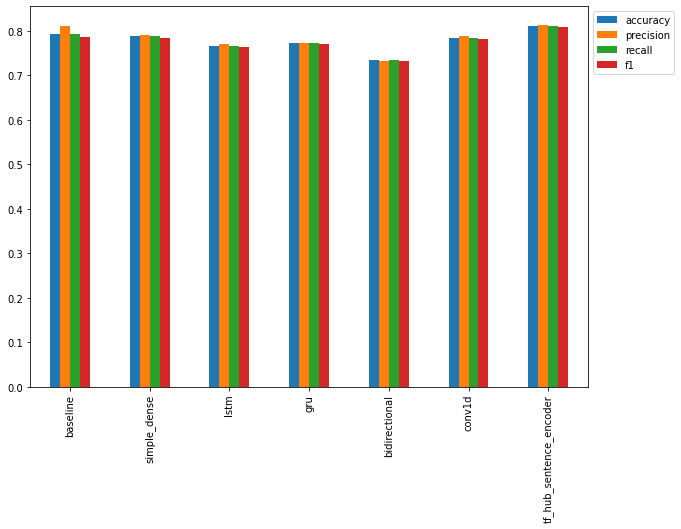

In [68]:
# Plot and compare all of the model results 
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

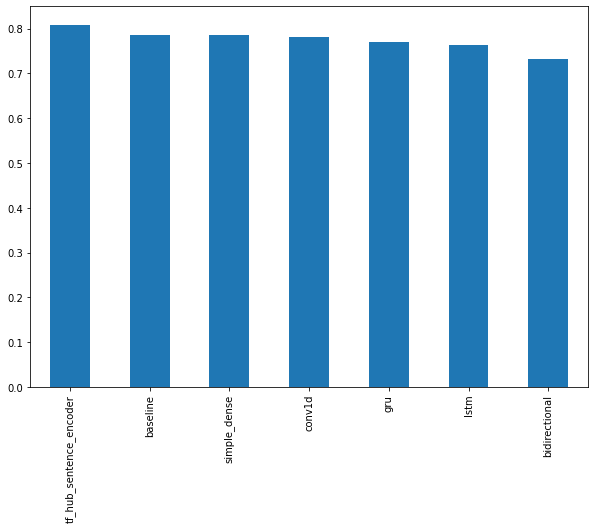

In [69]:
# Sort model results by f1-score 
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7));

In [70]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs \
   --name "NLP modelling experiments" \
   --description "A series of different NLP modellings experiments with various models" \
   --one_shot # exits the uploader when upload has finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=UDxfJ1mbHwbO0rQN8z1jtXUaZoNA2J&prompt=consent&access_type=offline


# **Combining Our Models(Models Ensembling/Stacking)**

**`Combine our baseline model(model_0), LSTM model(model_2) and our USE model trained(model_6) by averaging the combined prediction probabilities pf each`**

In [71]:
# Get the mean pred probs for 3 models 

baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # Get the prob from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3)
combined_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [72]:
# Calculate results from averaging the prediction probabilities 
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.87139107611549,
 'f1': 0.7876955870597856,
 'precision': 0.789001261975436,
 'recall': 0.7887139107611548}

In [73]:
all_model_results.loc['ensemble_results'] = ensemble_results

In [74]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc['ensemble_results']['accuracy'] = all_model_results.loc['ensemble_results']['accuracy']/100

In [75]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
lstm,0.766404,0.769346,0.766404,0.763583
gru,0.771654,0.773296,0.771654,0.769583
bidirectional,0.733596,0.733075,0.733596,0.732537
conv1d,0.784777,0.788386,0.784777,0.782178
tf_hub_sentence_encoder,0.811024,0.814034,0.811024,0.809202
ensemble_results,0.788714,0.789001,0.788714,0.787696


In [76]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs \
   --name "Natural Language Processing modelling experiments" \
   --description "A series of different NLP modellings experiments with various models to predict a tweet is disaster or not" \
   --one_shot # exits the uploader when upload has finished


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/uZkruxrDTbO0mIVGGjkO6A/

[2022-01-07T01:58:55] Started scanning logdir.
[2022-01-07T01:59:03] Total uploaded: 180 scalars, 0 tensors, 6 binary objects (2.6 MB)
[2022-01-07T01:59:03] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/uZkruxrDTbO0mIVGGjkO6A/


# **Saving and Loading a Trained Model**

In [77]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save('model_6.h5')

In [ ]:
# Load model with custom Hub Layer

loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4288 - accuracy: 0.8110


[0.4287995994091034, 0.8110235929489136]

In [ ]:
# Save TF Hub Sentence Encoder model to SavedModel format 
model_6.save('model_6_SavedModel_format')

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [ ]:
# Load TF Hub Sentences Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model('model_6_SavedModel_format')

In [ ]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 17ms/step - loss: 0.4288 - accuracy: 0.8110


[0.4287995994091034, 0.8110235929489136]

# **Finding the Most Wrong Examples**

In [ ]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_preds,
                       'pred_prob': tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.152844
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.736312
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988603
3,@camilacabello97 Internally and externally scr...,1,0.0,0.197141
4,Radiation emergency #preparedness starts with ...,1,1.0,0.729792


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob',ascending=False)
most_wrong.head()

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.921560
759,FedEx will no longer transport bioterror patho...,0,1.0,0.865775
628,@noah_anyname That's where the concentration c...,0,1.0,0.855722
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.848363
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.824746


> **`0 = Not a real disaster Tweet`**

> **`1 = Real disaster Tweet`**
   

In [ ]:
# Check the false positive (model predicted 1 when the real is 0)
for row in most_wrong[:10].itertuples():# loop through the top 10 rows
   _, text,target, pred, pred_prob = row
   print(f'Target: {target}, Pred: {int(pred)}, Prob: {pred_prob}')
   print(f'Text:\n{text}\n')
   print("----\n")


Target: 0, Pred: 1, Prob: 0.9215596318244934
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8657748699188232
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8557217121124268
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8483633995056152
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.824746310710907
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8086049556732178
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Pro

In [ ]:
# Check the false negative (model predicted 0 when the real is 1)
for row in most_wrong[-10:].itertuples():# loop through the bottom 10 rows
   _, text,target, pred, pred_prob = row
   print(f'Target: {target}, Pred: {int(pred)}, Prob: {pred_prob}')
   print(f'Text:\n{text}\n')
   print("----\n")

Target: 1, Pred: 0, Prob: 0.06631769239902496
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.05985207483172417
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.05880109220743179
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.05740509182214737
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.05462288111448288
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.0489574559032917
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.04370105266571045
Text:
Why are you deluged w

# **Making Predictions on the Test Dataset**

In [ ]:
# Making predictions on the test dataset
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences,10)
for i in test_samples:
  pred_prob = tf.squeeze(model_6.predict([i])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{i}\n")
  print("------\n")

Pred: 0, Prob: 0.09294652938842773
Text:
Survivors! Isabel Hodgins Danny Miller Laura Norton &amp; Mark Charnock take a group pic #SummerFate #BehindTheScenes https://t.co/qUKpVpwRFv

------

Pred: 0, Prob: 0.17177744209766388
Text:
NEW! Are souls punished with annihilation? http://t.co/cmNV6VyFCQ

------

Pred: 1, Prob: 0.7164760828018188
Text:
AngelRiveraLibÛ_ #Snowden 'may have' broken laws? Hurricane Katrina may have caused some damage. http://t.co/jAaWuiOvdc Without Snowden hÛ_

------

Pred: 1, Prob: 0.7758126854896545
Text:
@go2MarkFranco I spoke w Caleen Sisk. If #ShastaDam gets funded through Cali Emergency Drought Act I plan on doing story wfocus on Winnemem

------

Pred: 1, Prob: 0.9030653834342957
Text:
Chemical spill at a house in Hammondville. Emergency services attending. #BreakingNews #7News http://t.co/bQ94MjYgfe

------

Pred: 0, Prob: 0.11689276248216629
Text:
@cameron13131313 @OtooleDalton @averywelch23 @otoole1055 first of all you can't 'hit stick' shit.. Second

# **The Speed/Score Tradeoff**

**`Function to take a model and a number of samples and time how long the given model takes to make predictions on those samples`**

In [ ]:
# Calculate the time of predictions
import time 
def pred_timer(model, samples):
  """ 
  Times how long a model takes to make predictions on samples.

  Args: 
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # Get start time
  model.predict(samples) # Make predictions
  end_time = time.perf_counter() # Get finish time 
  total_time = end_time - start_time # Calculate how long predictions took to make 
  time_per_pred = total_time/len(val_sentences) # Fine prediction time per sample
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentences Encoder Prediction Times
model_6_total_pred_time, model_6_total_pred_time = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_total_pred_time

(0.000534756515747933, 0.000534756515747933)

In [ ]:
# Calculate Naive Bayes Prediction Times
model_6_total_pred_time, model_6_total_pred_time = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_total_pred_time